In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from scipy.optimize import minimize

In [2]:
#Description of function; optimising noisy models. 2D.

"""This corresponds to trying to optimise an unknown machine learning model. However, the initialization of the
model is very important, meaning your observations will be very noisy, and the problem might have a lot of 
local optima! You are trying to make the model’s log-likelihood as large as possible."""

'This corresponds to trying to optimise an unknown machine learning model. However, the initialization of the\nmodel is very important, meaning your observations will be very noisy, and the problem might have a lot of \nlocal optima! You are trying to make the model’s log-likelihood as large as possible.'

In [4]:
#Load datasets, append observations and queries
X = np.load('initial_inputs.npy')
y = np.load('initial_outputs.npy')

X_queries = [[0.65, 0.97],
             [0.989911, 0.558841],
             [0.7, 0.5],
             [0.859455, 0.999085],
             [0.982536, 0.008598],
             [0.073926, 0.823424],
             [0.730231, 0.321235], #Here is where I changed n_restarts_optimiser to 100.
             [0.666666, 0.      ],
             [0.001045, 0.000148],
             [0.135554, 0.000497],
             [0.151515, 0.666666],
             [0.577757, 0.467948]] 

y_observations = [0.42939466899612583,
                  -0.009015893207003104,
                  0.5693470693562224,
                  -0.009044434420832949,
                  0.007555953833578934,
                  -0.0252233158345328,
                  0.4400703592693548,
                  0.4606288851745046,
                  -0.11856957227811135,
                  0.05123141676995291,
                  0.03274877645078427,
                  0.02585132916249402]

X = np.append(X, X_queries).reshape(-1,2)
y = np.append(y, y_observations)

print(X)
print(y)

[[6.65799580e-01 1.23969128e-01]
 [8.77790989e-01 7.78627501e-01]
 [1.42699074e-01 3.49005131e-01]
 [8.45275429e-01 7.11120267e-01]
 [4.54647141e-01 2.90455180e-01]
 [5.77712844e-01 7.71973184e-01]
 [4.38166062e-01 6.85018257e-01]
 [3.41749593e-01 2.86977198e-02]
 [3.38648157e-01 2.13867246e-01]
 [7.02636557e-01 9.26564198e-01]
 [6.50000000e-01 9.70000000e-01]
 [9.89911000e-01 5.58841000e-01]
 [7.00000000e-01 5.00000000e-01]
 [8.59455000e-01 9.99085000e-01]
 [9.82536000e-01 8.59800000e-03]
 [7.39260000e-02 8.23424000e-01]
 [7.30231000e-01 3.21235000e-01]
 [6.66666000e-01 0.00000000e+00]
 [1.04500000e-03 1.48000000e-04]
 [1.35554000e-01 4.97000000e-04]
 [1.51515000e-01 6.66666000e-01]]
[ 0.53899612  0.42058624 -0.06562362  0.29399291  0.21496451  0.02310555
  0.24461934  0.03874902 -0.01385762  0.61120522  0.42939467 -0.00901589
  0.56934707 -0.00904443  0.00755595 -0.02522332  0.44007036  0.46062889
 -0.11856957  0.05123142  0.03274878]


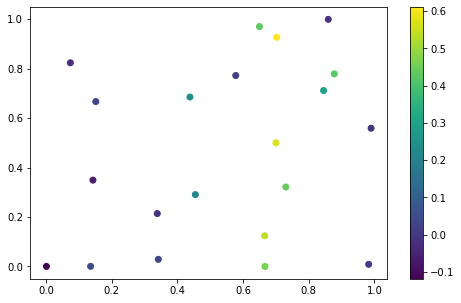

In [5]:
#Display points
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.colorbar()
plt.show()

In [7]:
# Create the Gaussian Process model (original solution)
gp_model = GaussianProcessRegressor()

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)

X_grid = []
for i in range(len(x1)):
    for j in range(len(x2)):
        X_grid.append([x1[i], x2[j]])

for _ in range(11):
    # Fit the GP model to existing observations
    gp_model.fit(X, y)

    # Define the acquisition function (UCB)
    mean, std = gp_model.predict(X_grid, return_std=True)
    ucb_values = mean + 0.96 * std  # kappa is a parameter to control exploration

    # Find the next point with maximum UCB value
    next_point = X_grid[np.argmax(ucb_values)]

next_point

[0.0, 1.0]

In [9]:
# Acquisition function (Upper Confidence Bound, UCB) using random samples
def ucb_acquisition(x, model, kappa=1):
    mean, std = model.predict(x.reshape(1, -1), return_std=True)
    return mean + kappa * std

# Define the Gaussian process model
kernel = RBF(1.0, length_scale_bounds="fixed")
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1000)

# Number of iterations or queries
num_queries = 1

# UCB parameter (adjust as needed)
kappa = 1.96

# Perform Bayesian optimization with UCB
for _ in range(num_queries):
    # Fit the Gaussian process model to the existing data
    model.fit(X, y)

    # Optimize the acquisition function to get the next query point
    next_query_point = None
    best_acquisition_value = -np.inf

    # Sample random points and select the one with the highest UCB value
    num_random_samples = 200000
    random_samples = np.random.rand(num_random_samples, 2)

    for sample in random_samples:
        acquisition_value = ucb_acquisition(sample, model, kappa)
        if acquisition_value > best_acquisition_value:
            best_acquisition_value = acquisition_value
            next_query_point = sample

    print("Next query point:", next_query_point)

Next query point: [0.00552812 0.999755  ]


In [6]:
# Define the Gaussian process model
kernel = Matern(length_scale=1.0)
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)

# Fit the Gaussian process model to existing data
gp_model.fit(X, y.reshape(-1, 1))

# Acquisition function: Expected Improvement (EI)
def expected_improvement(X, gp_model, best_observed_value, xi=0.1):
    mean, std_dev = gp_model.predict(X, return_std=True)

    with np.errstate(divide='warn'):
        z = (mean - best_observed_value - xi) / std_dev
        ei_values = (mean - best_observed_value - xi) * norm.cdf(z) + std_dev * norm.pdf(z)

    ei_values[np.isnan(ei_values)] = 0.0  # Handle NaN values

    return ei_values

# Choose the next points to query using Expected Improvement
best_observed_value = np.max(y)
candidate_points = np.random.rand(300000, 2)  # Randomly generate candidate points for illustration

ei_values = expected_improvement(candidate_points, gp_model, best_observed_value)
next_points = candidate_points[np.argmax(ei_values)]
next_points_rounded = np.round(next_points, decimals=6)

print("Next points to query:", next_points_rounded)

Next points to query: [0.577757 0.467948]


In [ ]:
#25/02 - Changed n_restarts_optimizer to 100 - noticed faield to converge = poor results? Used Matern kernel with EI
#02/03 - same approach
#Both RBF and Matern are now suggesting points close to 0,0 --> so trying this.
#again both suggesting the same point - so doing that